# IRT Solver - Iterative Refinement + MCMC - Simulated Data
t assume that each item measures a single sub-scale, and we report population scores on the same sub-scale. Thus, the problem can be solved separately for every sub-scale.

To test our non-parametric IRT model, we generate items with a parameteric form and sample student abilities from the standard prior distributions assumed in IRT literature. We then use our solver (simulated annealing and IRF refinement out loop, with MCMC estimation of $\theta$ within each step).

In [1]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.error
import nirt.irf
import nirt.likelihood
import nirt.mcmc
import nirt.run_recorder
import nirt.simulate.simulate_data
import nirt.simulate.plot_irf
import nirt.solver
import nirt.solver_mcmc
import numpy as np
import numpy.matlib
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

# Deterministic results.
numpy.random.seed(2)

In [2]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

In [3]:
# Algorithm parameters.
num_bins = 5
num_iterations = 3
num_theta_sweeps = 5
# Initial simulated annealing temperature.
temperature = 1
# IRF binning strategy.
grid_method = "quantile" # "uniform-fixed" # "quantile" # "uniform" 

In [4]:
X, theta_exact, b, c, v_exact = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination)
model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
print("v_exact", v_exact)

v_exact [1.]


(1000, 1)


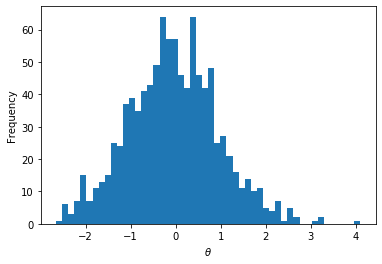

In [5]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
print(theta_exact.shape)
plt.hist(theta_exact[:, 0], 50)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

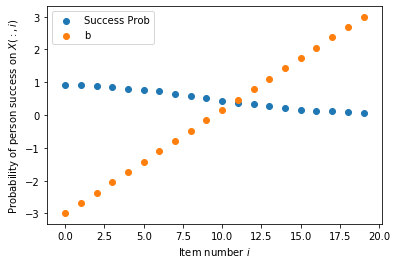

In [6]:
plt.scatter(range(I), np.sum(X, axis=0)/P, label="Success Prob")
plt.scatter(range(I), b, label="b")
plt.xlabel("Item number $i$")
plt.ylabel("Probability of person success on $X(:,i)$")
plt.legend()

# Initial Guess for $\theta$
Initial guess for $\theta_p^c$: the number of standard deviations person's c's success fraction is away from the mean success fraction of persons in items measuring sub-scale $c$.

When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s.

# Building IRFs from Sampled $\theta$
The IRF of item $i$ is a 1D function of $\theta$ in this case. Use a histogram of the currently "active" persons (those being estimated) to build the IRF.

In [7]:
theta = nirt.likelihood.initial_guess(X, c)
theta = (theta - np.mean(theta, axis=0))/np.std(theta, axis=0)
theta_init = theta

In [8]:
print("mean", np.mean(theta, axis=0))
print("std", np.std(theta, axis=0))

mean [3.55271368e-17]
std [1.]


In [9]:
# For each dimension, bin ALL persons by theta values into n bins. Binning strategy is either
# quantiles (so all bins have equal sizes) or uniform grid on a fixed domain [-M,M].
xlim = [(min(theta[:, ci])-1, max(theta[:, ci])+1) for ci in range(C)]
grid_all = [nirt.grid.Grid(theta[:, ci], num_bins, method=grid_method, xlim=xlim[ci]) for ci in range(C)]
irf_all = [nirt.irf.ItemResponseFunction(grid_all[ci], X[:, i]) for i, ci in enumerate(c)]
print("Grid limits", xlim)

Grid limits [(-4.014216588976931, 3.8005314018814125)]


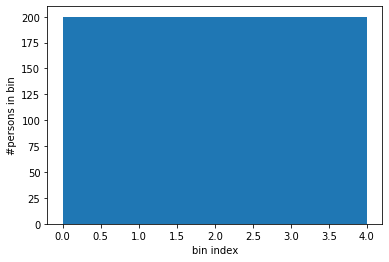

In [10]:
# Print the distribution of bin sizes.
plt.hist(grid_all[0].bin_index, num_bins)
plt.xlabel('bin index')
plt.ylabel('#persons in bin');

In [19]:
sample = np.arange(P, dtype=int)

# Index arrays for converting theta[active] into flattened form and back.
active = sample
person_ind = np.tile(active[:, None], C).flatten()
c_ind = np.tile(np.arange(C)[None, :], len(active)).flatten()
active_ind = (person_ind, c_ind)

In [20]:
e_all = nirt.error.error_norm_by_item(model_irf, irf_all)
print("IRF error of the {} items".format(I))
print("All samples: {:.3f} +- {:.3f}".format(e_all.mean(), e_all.std()))

IRF error of the 20 items
All samples: 0.041 +- 0.013


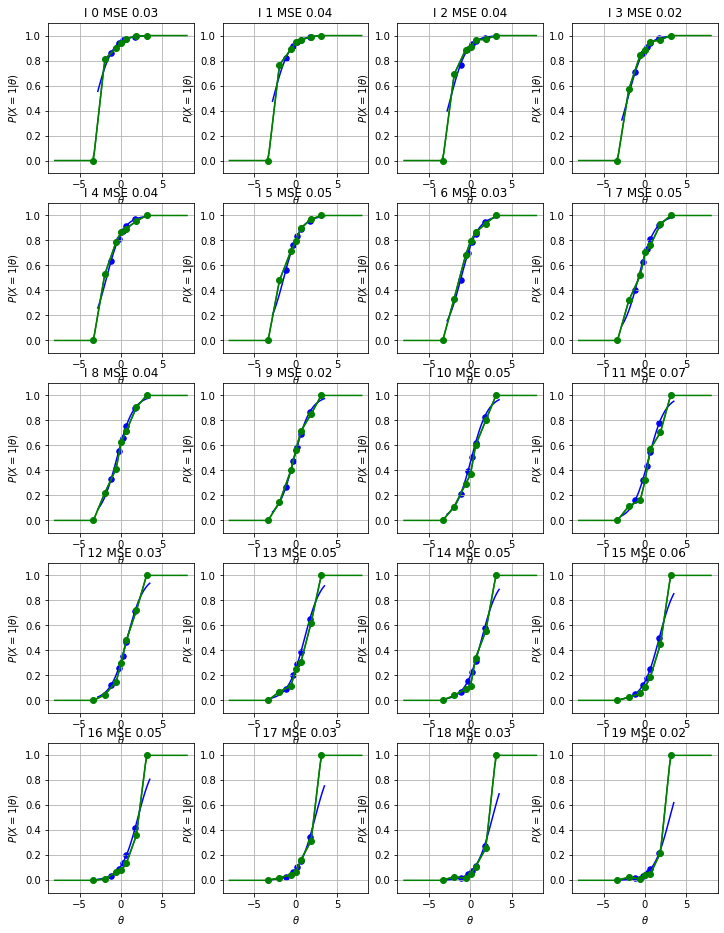

In [21]:
fig, axs = plt.subplots(I // 4, 4, figsize=(12, 0.8*I))
for i in range(I):
    ax = axs[i // 4, i % 4]
    nirt.simulate.plot_irf.plot_model_irf(ax, grid[c[i]], model_irf[i], num_bins, color="blue", label="Original")
    irf_all[i].plot(ax, color="green", label="{} samples".format(theta.shape[0]))
    ax.set_title("I {} MSE {:.2f}".format(i, e_all[i]))
    ax.grid(True)

$P_i(\theta)$ is generally monotonically increasing. The discrete approximation to the original synthetic (parametric) form is excellent. 20 persons per bin gives a reasonable approximation.

<!-- # Initial Guess for incoming $\theta$ (upon refinement)
When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s. -->

# Solver: Iterative IRF Refinement + MCMC for $\theta$

We run the following iterative refinement algorithm: start with 4 bins; IRF resolution is doubled; at each resolution theta is improved by MCMC iterations. After each MCMC step we update the IRF. Finish when IRF resolution is about
$[P/10]$.

In [27]:
# Run iterative refinement algorithm.
# v is fixed.
recorder = nirt.run_recorder.RunRecorder()
solver = nirt.solver_mcmc.SolverMcmc(
    X, c, num_iterations=num_iterations, num_theta_sweeps=num_theta_sweeps, grid_method=grid_method,
    recorder=recorder)

t = solver.solve()

INFO     Initial guess range [-3.01, 2.80] mean -0.00 std 1.00
INFO     Solving at IRF resolution 4
INFO     Iteration 1/3
INFO     log-likelihood -9122.67
INFO     MCMC sweep  0 log-likelihood -9221.0510 increase -98.38 accepted 35.10%
INFO     MCMC sweep  1 log-likelihood -9265.3493 increase -44.30 accepted 35.45%
INFO     MCMC sweep  2 log-likelihood -9321.7714 increase -56.42 accepted 36.03%
INFO     MCMC sweep  3 log-likelihood -9324.0608 increase -2.29 accepted 35.85%
INFO     MCMC sweep  4 log-likelihood -9342.9308 increase -18.87 accepted 35.64%
INFO     Iteration 2/3
INFO     log-likelihood -9593.55
INFO     MCMC sweep  0 log-likelihood -9608.9838 increase -15.43 accepted 35.30%
INFO     MCMC sweep  1 log-likelihood -9578.7583 increase 30.23 accepted 36.15%
INFO     MCMC sweep  2 log-likelihood -9584.2582 increase -5.50 accepted 37.03%
INFO     MCMC sweep  3 log-likelihood -9601.0805 increase -16.82 accepted 36.80%
INFO     MCMC sweep  4 log-likelihood -9565.4815 increase 35.6

INFO     MCMC sweep  1 log-likelihood -7380.4007 increase -29.28 accepted 40.55%
INFO     MCMC sweep  2 log-likelihood -7377.7297 increase 2.67 accepted 40.17%
INFO     MCMC sweep  3 log-likelihood -7373.9366 increase 3.79 accepted 40.90%
INFO     MCMC sweep  4 log-likelihood -7391.5574 increase -17.62 accepted 41.18%


(array([  3.,   8.,  37., 100., 170., 257., 235., 125.,  52.,  13.]),
 array([-3.65354957, -3.00965424, -2.3657589 , -1.72186356, -1.07796823,
        -0.43407289,  0.20982245,  0.85371778,  1.49761312,  2.14150846,
         2.78540379]),
 <a list of 10 Patch objects>)

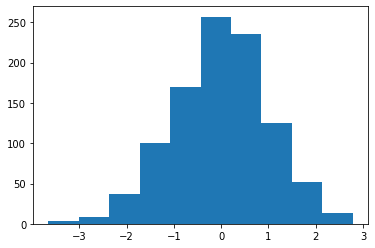

In [28]:
plt.hist(recorder.theta[64][1])

In [29]:
# Run history: calculate the IRF error from the known parametric model.

for resolution, value in recorder.irf.items():
    logger.info("IRF resolution {}".format(resolution))
    for j in range(len(value)):
        e = nirt.error.error_norm_by_item(model_irf, value[j])
        t = recorder.theta[resolution][j]
        logger.info("IRF error: {:.3f} +- {:.3f}\tt range {:.2f}, {:.2f}".format(
            e.mean(), e.std(), t.min(), t.max()))

INFO     IRF resolution 4
INFO     IRF error: 0.042 +- 0.014	t range -3.10, 3.16
INFO     IRF error: 0.074 +- 0.019	t range -3.42, 3.60
INFO     IRF error: 0.101 +- 0.020	t range -4.40, 3.36
INFO     IRF resolution 8
INFO     IRF error: 0.088 +- 0.019	t range -3.32, 3.70
INFO     IRF error: 0.083 +- 0.016	t range -4.20, 3.54
INFO     IRF error: 0.097 +- 0.025	t range -2.99, 3.63
INFO     IRF resolution 16
INFO     IRF error: 0.072 +- 0.018	t range -3.47, 3.75
INFO     IRF error: 0.079 +- 0.020	t range -3.62, 3.40
INFO     IRF error: 0.077 +- 0.018	t range -3.57, 3.07
INFO     IRF resolution 32
INFO     IRF error: 0.086 +- 0.022	t range -3.82, 3.15
INFO     IRF error: 0.095 +- 0.022	t range -4.04, 3.06
INFO     IRF error: 0.097 +- 0.023	t range -3.81, 2.98
INFO     IRF resolution 64
INFO     IRF error: 0.120 +- 0.023	t range -3.49, 2.87
INFO     IRF error: 0.133 +- 0.029	t range -3.65, 2.79
INFO     IRF error: 0.137 +- 0.030	t range -3.66, 2.68
INFO     IRF resolution 128
INFO     IRF e

[4, 8, 16, 32, 64, 128]


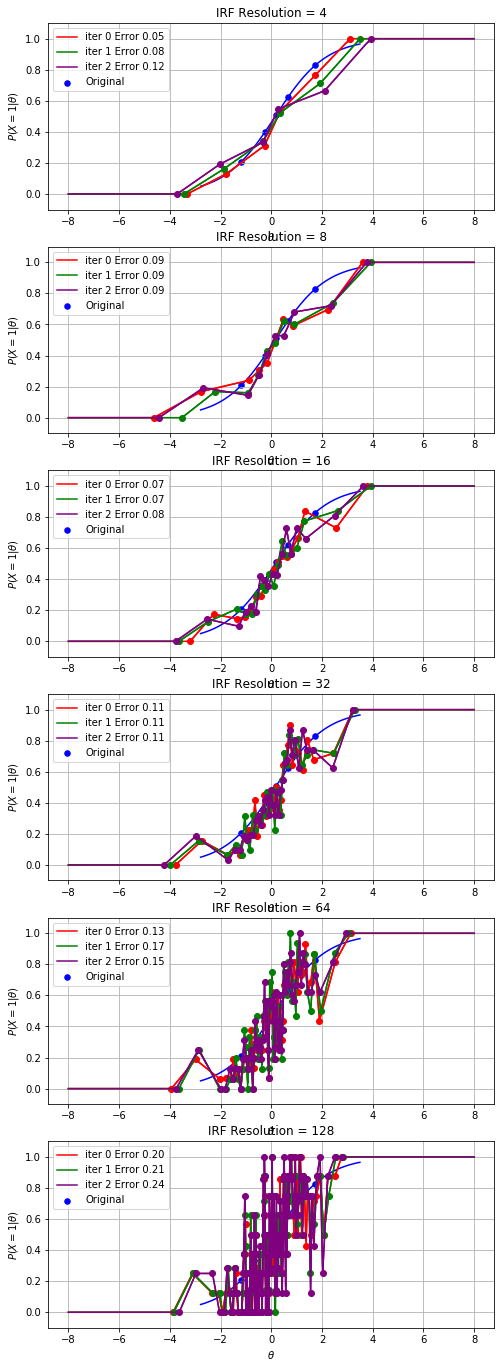

In [30]:
i = 10
resolutions = list(recorder.irf.keys())
print(resolutions)
fig, axs = plt.subplots(len(resolutions), 1, figsize=(8, 4*len(resolutions)))
for k, resolution in enumerate(resolutions):
    ax = axs[k]
    colors = ["red", "green", "purple", "orange"]
    nirt.simulate.plot_irf.plot_model_irf(ax, grid[c[i]], model_irf[i], num_bins, color="blue", label="Original")
    for k, irf in enumerate(recorder.irf[resolution]):
        irf[i].plot(ax, color=colors[k],
                    label="iter {} Error {:.2f}".format(
                        k, nirt.error.error_norm(model_irf[i], irf[i])))
    ax.set_title("IRF Resolution = {}".format(resolution))
    ax.grid(True)
    ax.legend()